# Détection de gravure par Deep Learning
### But : détecter toutes les gravures sur une image (pas de différences sémantiques)

On donne une carte de normale en entrée au réseau

Le dataset est générer dynamiquement par un générateur (les transformations également). Il suffit de donner les relevés, les cartes de normales et les masques de placement en paramètres.

In [1]:
!nvidia-smi

Wed Aug 27 17:33:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 5000                Off |   00000000:73:00.0  On |                  Off |
| 33%   36C    P8             25W /  230W |     880MiB /  16384MiB |     34%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Préparation des données

In [2]:
import os

folder_to_search = "./dataset/data_nino_gen/normale"

# DATA_NAMES = [f for f in os.listdir(folder_to_search) if f.endswith(".png")]
DATA_NAMES = ['os_0.png', 'os_1.png', 'os_5.png', 'os_2.png', 'os_3.png']
print(f"Found {len(DATA_NAMES)} images in {folder_to_search}")
print(DATA_NAMES)

Found 5 images in ./dataset/data_nino_gen/normale
['os_0.png', 'os_1.png', 'os_5.png', 'os_2.png', 'os_3.png']


In [3]:
BATCH_SIZE = 16
EPOCH_SIZE = 40*BATCH_SIZE
PATCH_SIZE = 512
IMG_FOLDER = "./dataset/data_nino_gen/normale"
GROUNDTRUTH_FOLDER = "./dataset/data_nino_gen/gravure"
# MASK_FOLDER = "./dataset/data_nino_gen/masque" # not needed anymore
PATCH_RATIO = 0.5 # for gravure dilation -> patch selection
ROTATION_STEP = 10
NOISE_SCALE = 64
NOISE_MAX_ANGLE = 5
RESCALE = 1.6

In [4]:
from src.dataGenerator import DataGenerator

gen = DataGenerator(
    DATA_NAMES, 
    BATCH_SIZE, 
    EPOCH_SIZE, 
    PATCH_SIZE, 
    IMG_FOLDER, 
    GROUNDTRUTH_FOLDER, 
    PATCH_RATIO, 
    ROTATION_STEP, 
    NOISE_SCALE,
    NOISE_MAX_ANGLE,
    RESCALE,
    flip=True,
)

2025-08-27 17:33:19.069732: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-27 17:33:19.071864: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-27 17:33:19.113087: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-27 17:33:19.114373: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-27 17:33:19.853361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

* Loaded image: os_0.png from ./dataset/data_nino_gen/normale
    Image shape: (1381, 4092, 3)
    Image min: 0.0, max: 255.0
* Loaded image: os_1.png from ./dataset/data_nino_gen/normale
    Image shape: (1381, 4092, 3)
    Image min: 0.0, max: 255.0
* Loaded image: os_5.png from ./dataset/data_nino_gen/normale
    Image shape: (1381, 4092, 3)
    Image min: 0.0, max: 255.0
* Loaded image: os_2.png from ./dataset/data_nino_gen/normale
    Image shape: (1381, 4092, 3)
    Image min: 0.0, max: 255.0
* Loaded image: os_3.png from ./dataset/data_nino_gen/normale
    Image shape: (1381, 4092, 3)
    Image min: 0.0, max: 255.0
* Loaded image: os_0.png from ./dataset/data_nino_gen/gravure
    Image shape: (1381, 4092, 1)
    Image min: 0.0, max: 1.0
* Loaded image: os_1.png from ./dataset/data_nino_gen/gravure
    Image shape: (1381, 4092, 1)
    Image min: 0.0, max: 1.0
* Loaded image: os_5.png from ./dataset/data_nino_gen/gravure
    Image shape: (1381, 4092, 1)
    Image min: 0.0, max: 1.

### Modèle

In [5]:
IMG_HEIGHT = PATCH_SIZE
IMG_WIDTH = PATCH_SIZE
IMG_CHANNELS = 3  # 1 for grayscale

In [9]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, Conv2DTranspose

def build_unet(input_shape):
    # For 2D RGB input (batch, height, width, channels), use Conv2D, MaxPooling2D, etc.
    # receptive field ~= 100x100

    inputs = Input(input_shape)

    # Downsampling
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    b = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(b)

    # Upsampling
    u3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(b)
    u3 = concatenate([u3, c3])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)

    u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(c4)
    u2 = concatenate([u2, c2])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u2)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)

    u1 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(c5)
    u1 = concatenate([u1, c1])
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u1)
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer='he_normal')(c6)

    return Model(inputs, outputs)

def build_unet_big(input_shape):
    # receptive field ~= 800x800 with 6 downsampling layers 
    # ~ 400x400 with 5

    inputs = Input(input_shape)
    # Downsampling
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    # c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p5)
    # c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)
    # p6 = MaxPooling2D((2, 2))(c6)

    # Bottleneck
    b = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p5)
    b = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(b)

    # Upsampling
    # u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(b)
    # u6 = concatenate([u6, c6])
    # c7 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    # c7 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(b)
    u5 = concatenate([u5, c5])
    c8 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u5)
    c8 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

    u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(c8)
    u4 = concatenate([u4, c4])
    c9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u4)
    c9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

    u3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(c9)
    u3 = concatenate([u3, c3])
    c10 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u3)
    c10 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c10)

    u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(c10)
    u2 = concatenate([u2, c2])
    c11 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u2)
    c11 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c11)

    u1 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(c11)
    u1 = concatenate([u1, c1])
    c12 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u1)
    c12 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c12)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer='he_normal')(c12)

    return Model(inputs, outputs)

model = build_unet_big((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.summary()


2025-08-27 17:33:51.502376: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

#### Champ réceptif du modèle

Utiliser juste pour vérifier le modèle (Attention, cela réinitialise les poids)

1/1 [==============================] - 0s 382ms/step


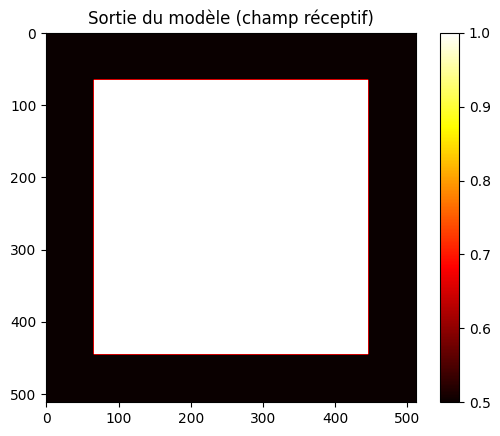

In [7]:
# Initialiser uniquement les coefficients (poids) du modèle à 1, laisser les biais inchangés
for layer in model.layers:
    if hasattr(layer, 'kernel_initializer'):
        weights = layer.get_weights()
        if weights:
            # Généralement, le premier élément est le kernel, le second le biais (si présent)
            new_weights = []
            for i, w in enumerate(weights):
                if i == 0:  # kernel/coefficients
                    new_weights.append(np.ones(w.shape, dtype=w.dtype))
                else:  # biais ou autres
                    new_weights.append(w)
            layer.set_weights(new_weights)

# Créer une image noire avec un pixel blanc au centre
input_img = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
center_h = IMG_HEIGHT // 2
center_w = IMG_WIDTH // 2
input_img[0, center_h, center_w, :] = 1.0

# Prédiction
output = model.predict(input_img)[0, ..., 0]

import matplotlib.pyplot as plt
plt.imshow(output, cmap='hot')
plt.title("Sortie du modèle (champ réceptif)")
plt.colorbar()
plt.show()

### Training

In [6]:
# Losses
def dice_loss(y_true, y_pred, smooth=1e-8):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true*y_pred) #, axis=[1,2,3])
    
    # union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
    # dice = (2. * intersection + smooth) / (union + smooth)

    den1 = tf.reduce_sum(y_true * y_true) #, axis=[1, 2, 3])
    den2 = tf.reduce_sum(y_pred * y_pred) #, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (den1 + den2 + smooth)

    return 1 - tf.reduce_mean(dice)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def focal_dice_loss(y_true, y_pred, lambda_bfce=1.0):
    bfce = tf.keras.losses.BinaryFocalCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return lambda_bfce * bfce + dice

# Metrics
def f1_score_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    return f1

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(filepath=f'checkpoints/best.weights.h5', save_weights_only=True, save_best_only=True, monitor='loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='loss', patience=10, mode='min', verbose=1)

#### Learning rate Schedulers

In [9]:
import tensorflow_addons as tfa

learning_rate_start = 1e-1
learning_rate_end = 1e-4

lr_schedule_poly = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=learning_rate_start,
    decay_steps=500,
    end_learning_rate=learning_rate_end,
    power=1.0
)

lr_schedule_exp = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate_start,
    decay_steps=500,
    decay_rate= learning_rate_end / learning_rate_start,
    staircase=False
)

steps_per_epoch = EPOCH_SIZE // BATCH_SIZE
lr_schedule_cycle = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=learning_rate_start,
    maximal_learning_rate=learning_rate_end,
    step_size=2 * steps_per_epoch,
    scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
    scale_mode='cycle'
)

/home/nrr6650/dev/detection_gravure/.venv/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#### Fitting model

In [ ]:
# adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
# adamW = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
# rmsprop = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
# sgd = tf.keras.optimizers.SGD(learning_rate=lr_schedule_cycle)

adam2 = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.5, beta_2=0.5, epsilon=1e-07, amsgrad=False)

np.seterr(all='raise') # to check where nan are created
tf.debugging.enable_check_numerics() # but it slows the code
# nan_callback = tf.keras.callbacks.TerminateOnNaN() # essayer ça sinon

model.compile(
    optimizer=adam2,
    loss=focal_dice_loss,
    metrics=[f1_score_metric, dice_loss]
)

history = model.fit(
    gen,
    epochs=20,
    #callbacks=[checkpoint, early_stopping]
)

model.save('unet_model_from_normals.h5')

# import gc
# globals().clear()

# # kill the kernel to free up memory
# import os
# os._exit(0)  # This will terminate the kernel and free up memory


Epoch 1/20
40/40 [==============================] - 482s 12s/step - loss: 0.7916 - f1_score_metric: 0.0981 - dice_loss: 0.7491
Epoch 2/20
40/40 [==============================] - 473s 12s/step - loss: 0.6547 - f1_score_metric: 0.1794 - dice_loss: 0.6265
Epoch 3/20
 3/40 [=>............................] - ETA: 7:15 - loss: 0.6412 - f1_score_metric: 0.1943 - dice_loss: 0.6117

### Courbes & prédictions des batchs

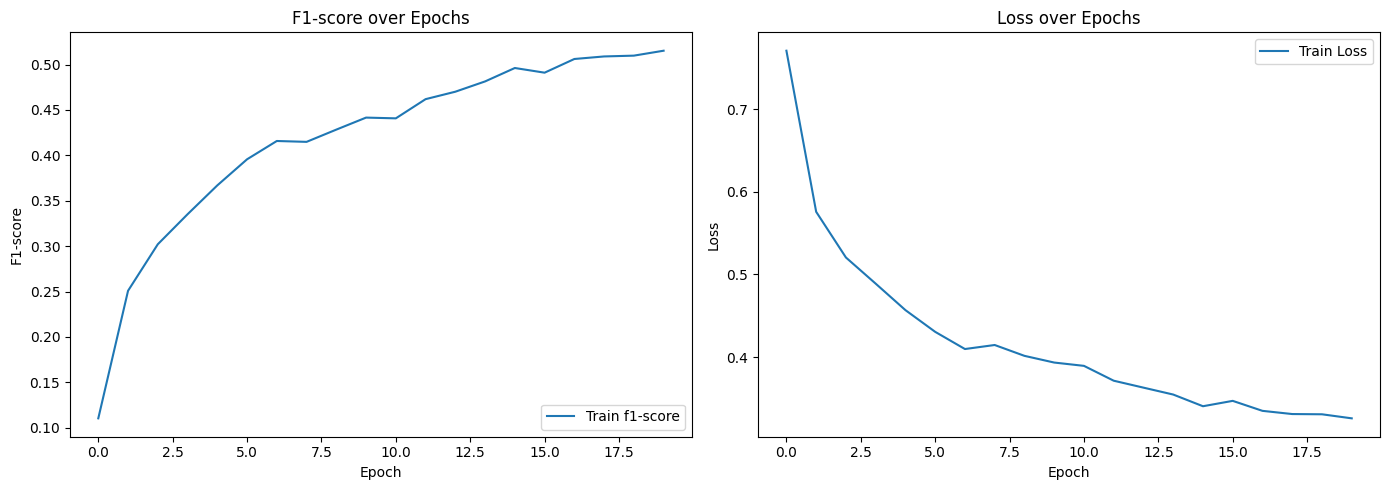

In [9]:
import matplotlib.pyplot as plt

# Récupération des données
acc = history.history['f1_score_metric']
loss = history.history['loss']
epochs_range = range(len(acc))

# Création des graphiques
plt.figure(figsize=(14, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train f1-score')
plt.title('F1-score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend(loc='lower right')

# Perte
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


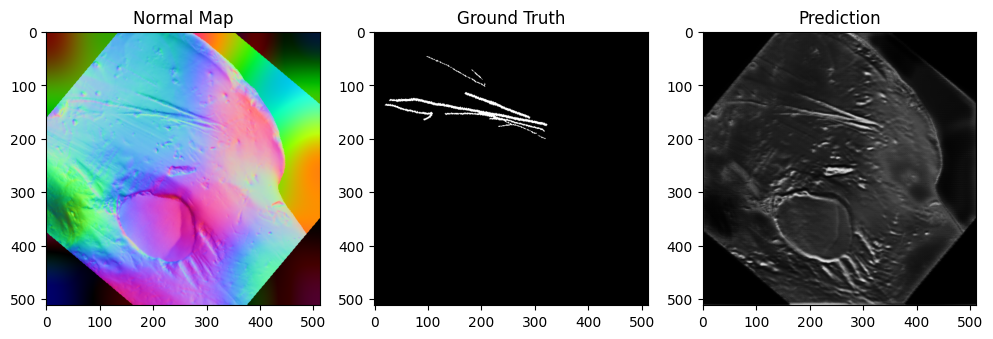

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


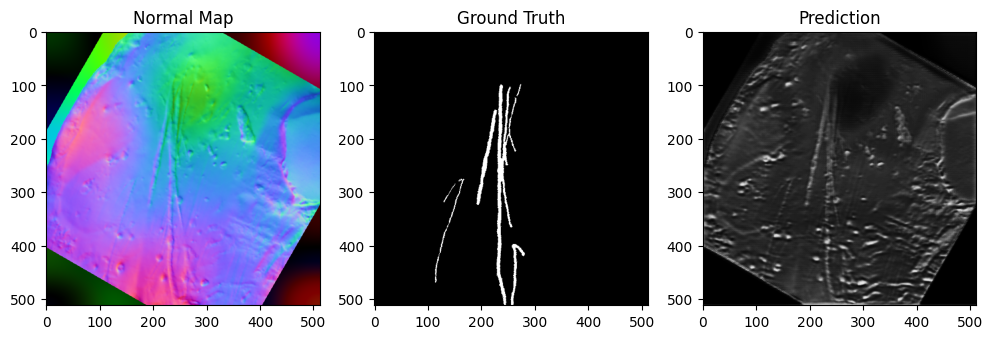

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


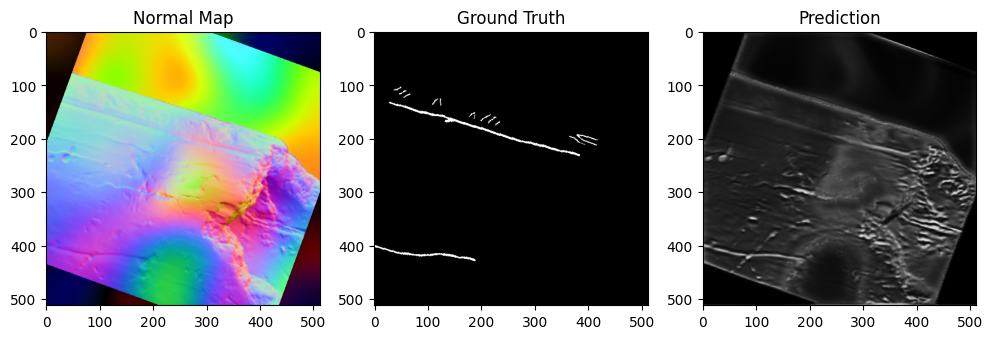

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


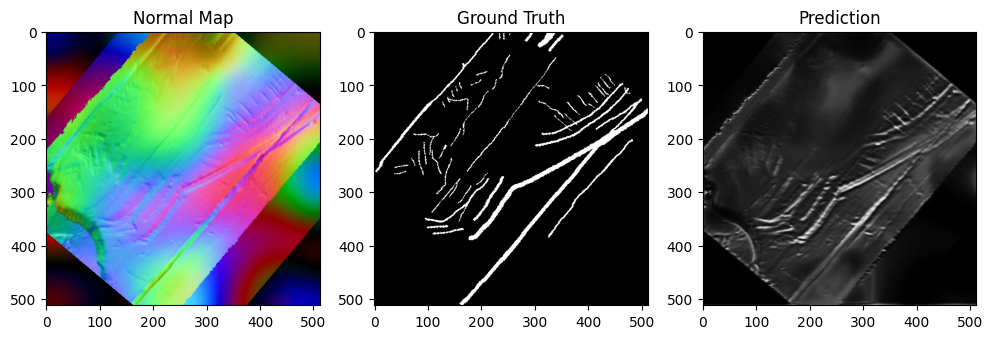

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


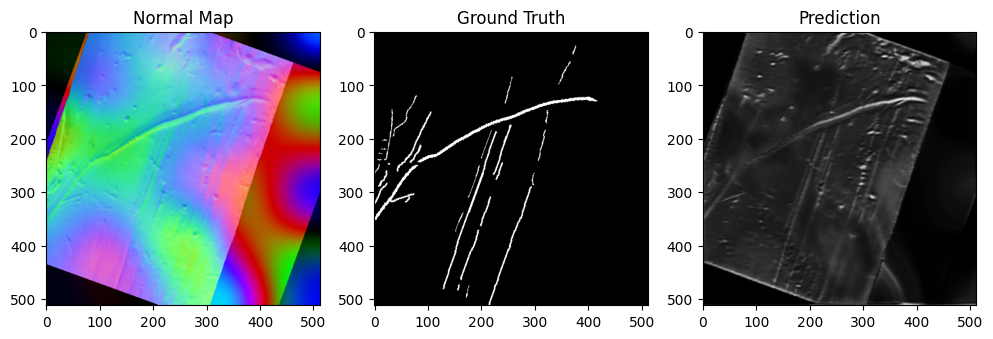

In [9]:
from tensorflow.keras.models import load_model

# Charger le modèle depuis le fichier .h5

model = load_model('unet_model_from_normals.h5', custom_objects={'focal_dice_loss': focal_dice_loss, 'f1_score_metric': f1_score_metric, 'dice_loss': dice_loss})

# Prédiction sur quelques images du générateur
X_batch, y_batch = gen[0]  # Prend un batch
# X_batch, y_batch = train_gen[0]  # Prend un batch
preds = model.predict(X_batch)

import matplotlib.pyplot as plt

for i in range(min(5, X_batch.shape[0])):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow((X_batch[i] + 1 )/2)  # Inverse normalization to [0, 1]
    plt.title("Normal Map")

    plt.subplot(1, 3, 2)
    plt.imshow(y_batch[i], cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(preds[i, ..., 0], cmap='gray')
    plt.title("Prediction")
    plt.show()


### Utilisation sur des données réels

In [11]:
# l'image est redimensionnée à Height x Width
IMG_PATH = './test_imgs/omoplate.png'
MODEL_NAME = 'unet_model_from_normals.h5'
MODEL_WEIGHTS = 'checkpoints/best.weights.h5'

# charger le modèle avec les poids
model = load_model(MODEL_NAME, custom_objects={'focal_dice_loss': focal_dice_loss, 'f1_score_metric': f1_score_metric, 'dice_loss': dice_loss})
#model.load_weights(MODEL_WEIGHTS)

1/1 [==============================] - 0s 365ms/step


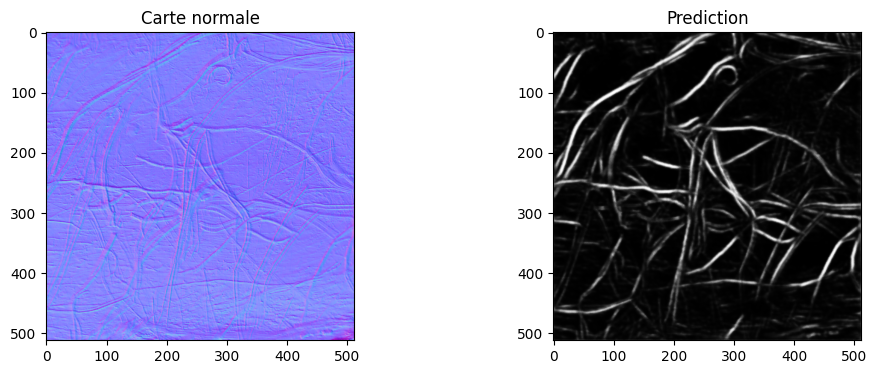

In [12]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Charger et prétraiter la carte normale
carte_normale = load_img(IMG_PATH, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="rgb")
carte_normale_arr = img_to_array(carte_normale) / 127.5 - 1
carte_normale_arr = np.expand_dims(carte_normale_arr, axis=0)  # shape: (1, H, W, 3)

# Prédiction du modèle
pred = model.predict(carte_normale_arr)[0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(carte_normale)
plt.title("Carte normale")

plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='gray')
plt.title("Prediction")
plt.show()